In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchsummary import summary

import time
import copy
import os

In [2]:
data_dir = '../../../../IIT/IIT Sem 7/IE 643/Challenge_Dataset/Images'
mask_dir = '../../../../IIT/IIT Sem 7/IE 643/Challenge_Dataset/Masks'

In [3]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Train2': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=1),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
}
mask_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]),
    'Train2': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
}

In [4]:
class ImageMaskDataset(Dataset):
    def __init__(self, data_dir, mask_dir, train = True, transform = None, transform2 = None, mask_transform = None, mask_transform2 = None) -> None:
        super(ImageMaskDataset, self).__init__()
        self.imgs = []
        self.transform = transform
        if train:
            for file1 in os.scandir(data_dir+'/Train'):
                file2 = mask_dir+'/Train/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                    for i in range(len(transform2)):
                        self.imgs.append((transform2[i](Image.open(file1.path).convert('RGB')),mask_transform2[i](Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
        else:
            for file1 in os.scandir(data_dir+'/Validation'):
                file2 = mask_dir+'/Validation/'+file1.name[:-3]+'png'
                if self.transform is not None:
                    self.imgs.append((self.transform(Image.open(file1.path).convert('RGB')),mask_transform(Image.open(file2))))
                else:
                    self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2)))
                    # if self.imgs[-1][0].shape[0] == 1:
                    #     self.imgs[-1] = (self.imgs[-1][0].repeat(3,1,1), self.imgs[-1][1])
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [5]:
train_data = ImageMaskDataset(data_dir, mask_dir, train = True, transform=data_transforms['Train'], transform2=[data_transforms['Train2']], mask_transform=mask_transforms['Train'], mask_transform2=[mask_transforms['Train2']])
val_data = ImageMaskDataset(data_dir, mask_dir, train = False, transform=data_transforms['Validation'], mask_transform=mask_transforms['Validation'])

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size = 16,
    shuffle = True,
)
val_loader = DataLoader(
    val_data,
    batch_size = 16,
    shuffle = True,
)

In [7]:
def image_show(image, mask, pred = None):
    image = image*0.5 + 0.5
    mask = mask*0.5 + 0.5
    plt.figure(figsize=(20,10))
    if pred is not None:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('True Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(pred.detach().numpy().transpose((1,2,0)), cmap='gray')
    else:
        plt.subplot(1,3,1)
        plt.title('Image')
        plt.imshow(image.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title('Mask')
        plt.imshow(mask.numpy().transpose((1,2,0)), cmap='gray')

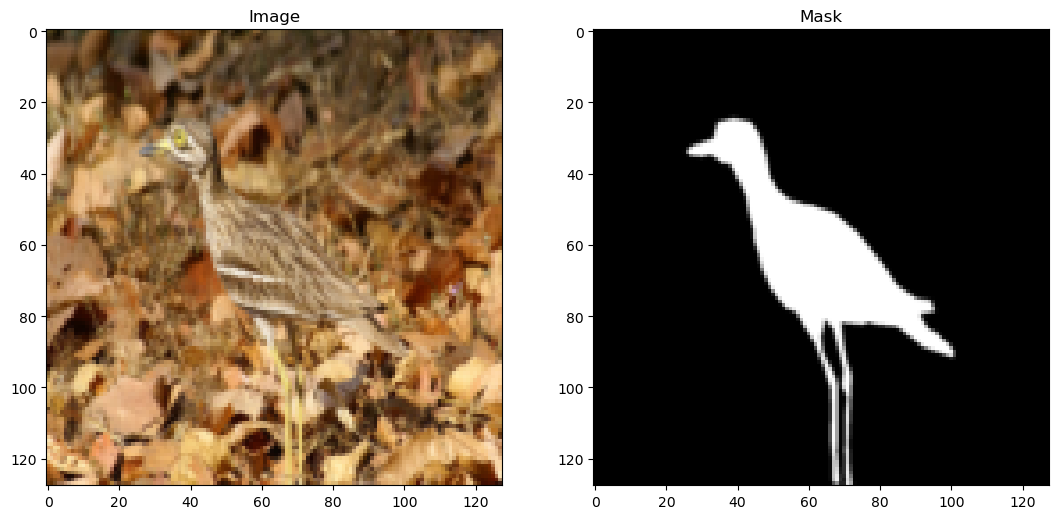

In [8]:
dataiter = iter(train_loader)
image, mask = next(dataiter)
index = 0
image_show(image[index], mask[index])

In [9]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [10]:
class DenseBlock(nn.Sequential):
    def __init__(self, channels: int, output_channels: int) -> None:
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels+0*output_channels, output_channels, 9, 1, 'same')
        self.norm1 = nn.BatchNorm2d(output_channels)
        self.conv2 = nn.Conv2d(channels+1*output_channels, output_channels, 9, 1, 'same')
        self.norm2 = nn.BatchNorm2d(output_channels)
        self.conv3 = nn.Conv2d(channels+2*output_channels, output_channels, 7, 1, 'same')
        self.norm3 = nn.BatchNorm2d(output_channels)
        self.conv4 = nn.Conv2d(channels+3*output_channels, output_channels, 7, 1, 'same')
        self.norm4 = nn.BatchNorm2d(output_channels)
        self.conv5 = nn.Conv2d(channels+4*output_channels, output_channels, 5, 1, 'same')
        self.norm5 = nn.BatchNorm2d(output_channels)
        self.conv6 = nn.Conv2d(channels+5*output_channels, output_channels, 5, 1, 'same')
        self.norm6 = nn.BatchNorm2d(output_channels)
        self.conv7 = nn.Conv2d(channels+6*output_channels, output_channels, 3, 1, 'same')
        self.norm7 = nn.BatchNorm2d(output_channels)
        self.conv8 = nn.Conv2d(channels+7*output_channels, output_channels, 3, 1, 'same')
        self.norm8 = nn.BatchNorm2d(output_channels)
        self.convFinal = nn.Conv2d(channels+8*output_channels, channels, 1)
        self.normFinal = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        temp = x
        x_temp = torch.relu(self.norm1(self.conv1(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm2(self.conv2(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm3(self.conv3(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm4(self.conv4(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm5(self.conv5(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm6(self.conv6(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm7(self.conv7(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm8(self.conv8(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x = torch.relu(self.normFinal(self.convFinal(temp)))
        return x

In [11]:
den = DenseBlock(512,64)
summary(den, (512,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]       2,654,272
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3           [-1, 64, 16, 16]       2,986,048
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5           [-1, 64, 16, 16]       2,007,104
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]       2,207,808
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]       1,228,864
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]       1,331,264
      BatchNorm2d-12           [-1, 64, 16, 16]             128
           Conv2d-13           [-1, 64, 16, 16]         516,160
      BatchNorm2d-14           [-1, 64,

In [12]:
class UNet(nn.Module):
    def __init__(self) -> None:
        super(UNet, self).__init__()

        # ENCODER
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 'same') # 128, 128, 3 --> 128, 128, 64
        self.norm1 = nn.BatchNorm2d(64)
        self.denseBlock1 = DenseBlock(64, 16).to(device)

        self.maxpool1 = nn.MaxPool2d(2,2) # 64, 64, 64

        self.conv2 = nn.Conv2d(64, 128, 3, 1, 'same') # 64, 64, 64 --> 64, 64, 128
        self.norm2 = nn.BatchNorm2d(128)
        self.denseBlock2 = DenseBlock(128, 32).to(device) # 64, 64, 128

        self.maxpool2 = nn.MaxPool2d(2,2) # 32, 32, 128

        self.conv3 = nn.Conv2d(128, 256, 3, 1, 'same') # 32, 32, 128 --> 32, 32, 256
        self.norm3 = nn.BatchNorm2d(256)
        self.denseBlock3 = DenseBlock(256, 64).to(device) # 32, 32, 256

        self.maxpool3 = nn.MaxPool2d(2,2) # 16, 16, 256

        self.conv4 = nn.Conv2d(256, 512, 3, 1, 1) # 16, 16, 256 --> 16, 16, 512
        self.norm4 = nn.BatchNorm2d(512)
        self.denseBlock4 = DenseBlock(512, 128).to(device) # 16, 16, 512

        self.maxpool4 = nn.MaxPool2d(2,2) # 8, 8, 512

        self.conv41 = nn.Conv2d(512, 1024, 3, 1, 1) # 8, 8, 1024 --> 8, 8, 1024
        self.norm41 = nn.BatchNorm2d(1024)
        self.denseBlock41 = DenseBlock(1024, 256).to(device) # 8, 8, 1024


        # DECODER
        self.convT0 = nn.ConvTranspose2d(1024, 512, 2, 2)

        self.denseBlock42 = DenseBlock(1024, 256).to(device)

        self.convT1 = nn.ConvTranspose2d(1024, 256, 2, 2)

        self.denseBlock5 = DenseBlock(512, 128).to(device)

        self.convT2 = nn.ConvTranspose2d(512, 128, 2, 2)

        self.denseBlock6 = DenseBlock(256, 64).to(device)

        self.convT3 = nn.ConvTranspose2d(256, 64, 2, 2)

        self.denseBlock7 = DenseBlock(128, 32).to(device)

        self.conv71 = nn.Conv2d(128, 64, 3, 1, 'same')
        self.norm71 = nn.BatchNorm2d(64)
        self.conv72 = nn.Conv2d(64, 16, 5, 1, 'same')
        self.norm72 = nn.BatchNorm2d(16)
        self.conv73 = nn.Conv2d(16, 1, 1, 1, 'same')
        self.norm73 = nn.BatchNorm2d(1)

    def forward(self, x):
        # ENCODER
        x = torch.relu(self.norm1(self.conv1(x)))
        x_temp1 = self.denseBlock1(x)

        x = self.maxpool1(x_temp1)

        x = torch.relu(self.norm2(self.conv2(x)))
        x_temp2 = self.denseBlock2(x)

        x = self.maxpool2(x_temp2)

        x = torch.relu(self.norm3(self.conv3(x)))
        x_temp3 = self.denseBlock3(x)

        x = self.maxpool3(x_temp3)

        x = torch.relu(self.norm4(self.conv4(x)))
        x_temp4 = self.denseBlock4(x)

        x = self.maxpool3(x_temp4)

        x = torch.relu(self.norm41(self.conv41(x)))
        x = self.denseBlock41(x)

        # DECODER
        x = self.convT0(x)

        x = torch.cat((x,x_temp4), 1)

        x = self.denseBlock42(x)

        x = self.convT1(x)

        x = torch.cat((x,x_temp3), 1)

        x = self.denseBlock5(x)

        x = self.convT2(x)

        x = torch.cat((x,x_temp2), 1)

        x = self.denseBlock6(x)

        x = self.convT3(x)   

        x = torch.cat((x,x_temp1), 1)

        x = self.denseBlock7(x)

        x = torch.relu(self.norm71(self.conv71(x)))
        x = torch.relu(self.norm72(self.conv72(x)))
        x = torch.sigmoid(self.norm73(self.conv73(x)))

        return x

In [13]:
unet = UNet().to(device)

In [14]:
summary(copy.deepcopy(unet).to('cpu'), (3, 128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 16, 128, 128]          82,960
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5         [-1, 16, 128, 128]         103,696
       BatchNorm2d-6         [-1, 16, 128, 128]              32
            Conv2d-7         [-1, 16, 128, 128]          75,280
       BatchNorm2d-8         [-1, 16, 128, 128]              32
            Conv2d-9         [-1, 16, 128, 128]          87,824
      BatchNorm2d-10         [-1, 16, 128, 128]              32
           Conv2d-11         [-1, 16, 128, 128]          51,216
      BatchNorm2d-12         [-1, 16, 128, 128]              32
           Conv2d-13         [-1, 16, 128, 128]          57,616
      BatchNorm2d-14         [-1, 16, 1

# IoU Function

In [18]:
def binaryJaccardIndex(preds, masks):
    intersection = 0
    union = 0
    for pred, mask in zip(preds, masks):
        for pred_row, mask_row in zip(pred[0],mask[0]):
            for i,j in zip(pred_row, mask_row):
                if i==1 or j==1:
                    union+=1
                if i==1 and j==1:
                    intersection+=1
    return(intersection/union)

# Binary Cross Entropy Loss

In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(unet.parameters(), lr=5e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.6)

In [19]:
num_epochs = 10
batches = len(train_loader)
losses = []
print(batches)

125


In [20]:
best_weights = copy.deepcopy(unet.state_dict())
max = 0
val_iou_score = 0
tic = time.time()
for epoch in range(num_epochs):
    unet.train()
    print(f'Epoch {epoch+1}/{num_epochs}; LR = {scheduler.get_last_lr()[0]}')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks).to(device)

        preds = unet(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    with torch.no_grad():
        unet.eval()
        val_iou_score = 0
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to('cpu')
            pred = unet(image).cpu()
            pred = torch.round(pred)
            val_iou_score += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
        val_iou_score = val_iou_score/len(val_loader)

        if (max <= val_iou_score):
            print('SAVED MODEL WEIGHTS')
            max = val_iou_score
            best_weights = copy.deepcopy(unet.state_dict())
    
    print(f'Validation IoU Score: {val_iou_score:.4f}')
    print(f'Validation Dice Score: {(2*val_iou_score)/(1+val_iou_score):.4f}')
    print("-"*20)
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/10; LR = 0.5
Step 1/125; Loss = 0.5583
Step 2/125; Loss = 0.5318
Step 3/125; Loss = 0.5333
Step 4/125; Loss = 0.4856
Step 5/125; Loss = 0.4876
Step 6/125; Loss = 0.5161
Step 7/125; Loss = 0.4961
Step 8/125; Loss = 0.4689
Step 9/125; Loss = 0.4307
Step 10/125; Loss = 0.4447
Step 11/125; Loss = 0.4917
Step 12/125; Loss = 0.4703
Step 13/125; Loss = 0.4435
Step 14/125; Loss = 0.3654
Step 15/125; Loss = 0.4181
Step 16/125; Loss = 0.3858
Step 17/125; Loss = 0.3886
Step 18/125; Loss = 0.3990
Step 19/125; Loss = 0.4380
Step 20/125; Loss = 0.4087
Step 21/125; Loss = 0.4606
Step 22/125; Loss = 0.3955
Step 23/125; Loss = 0.3786
Step 24/125; Loss = 0.4212
Step 25/125; Loss = 0.3978
Step 26/125; Loss = 0.3740
Step 27/125; Loss = 0.4190
Step 28/125; Loss = 0.3855
Step 29/125; Loss = 0.3469
Step 30/125; Loss = 0.4352
Step 31/125; Loss = 0.3899
Step 32/125; Loss = 0.4087
Step 33/125; Loss = 0.4784
Step 34/125; Loss = 0.4192
Step 35/125; Loss = 0.3880
Step 36/125; Loss = 0.3226
Step 37/125; Los

Text(0.5, 1.0, 'Loss vs Epochs')

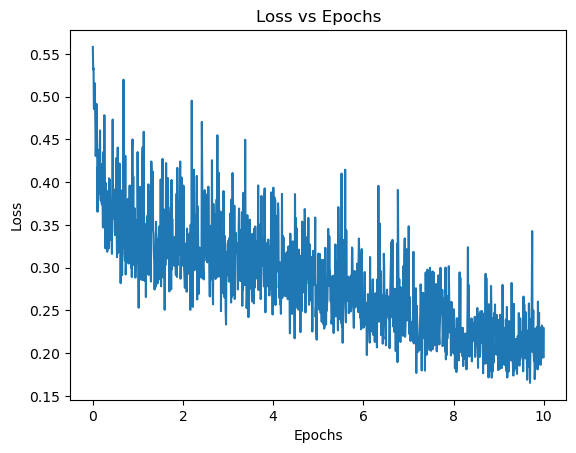

In [21]:
plt.plot(np.linspace(0,num_epochs,len(losses)),losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

In [30]:
# unet.load_state_dict(best_weights)
# torch.save(unet, '../models/U-Net_Image_Segmentation_IE643_Final_Dense.pt')

In [15]:
unet = torch.load('../models/U-Net_Image_Segmentation_IE643_Final_Dense.pt')
unet.eval()

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock1): DenseBlock(
    (conv1): Conv2d(64, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(80, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(96, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(112, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (norm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(128, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (norm5): BatchNorm2d(16, eps=1e-05, m

# Testing

In [23]:
threshold = 0.39

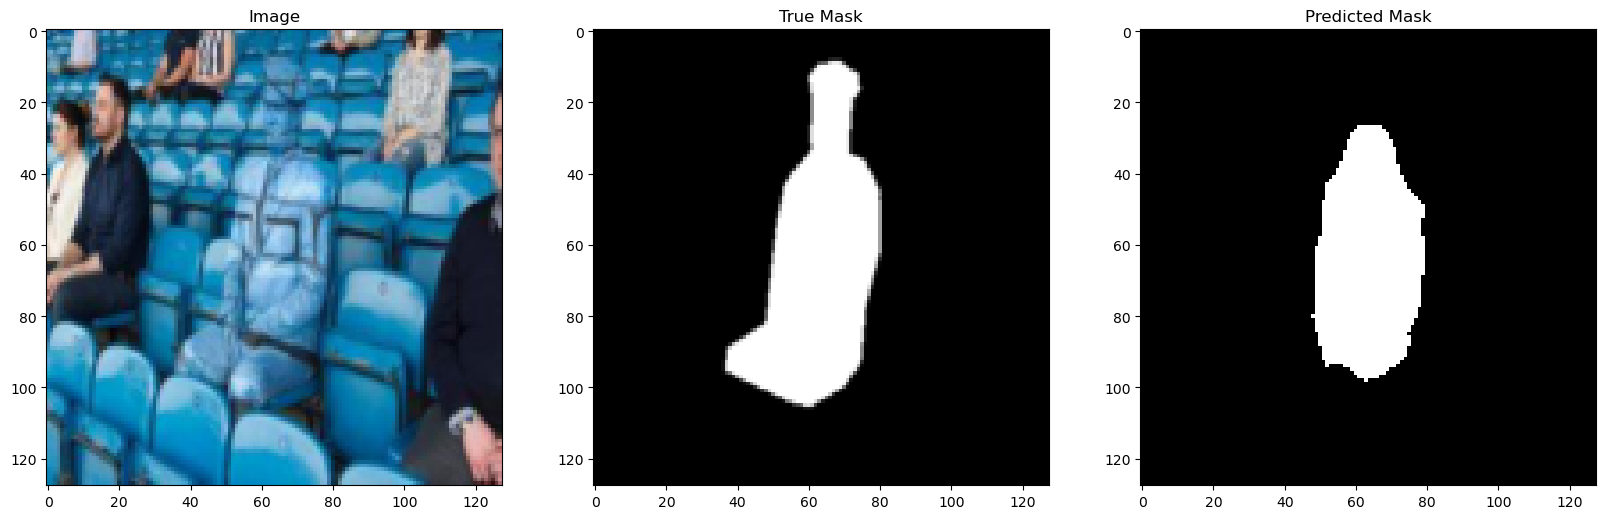

In [33]:
with torch.no_grad():
    image, mask = next(iter(train_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred1 = torch.relu(torch.sign(pred - threshold))
    image = image.to('cpu')
    image_show(image[0], mask[0], pred1[0])

In [28]:
IoU_value = 0
with torch.no_grad():
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = unet(image).cpu()
        pred = torch.relu(torch.sign(pred - threshold)) # Taking 0.4 as the threshold to make the value 1
        IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
    print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')

Intersection Over Union value = 0.6416209912903983


In [29]:
iou = IoU_value/len(train_loader)
dice_score = 2*iou/(1+iou)
print('Dice Score for Training data =',dice_score)

Dice Score for Training data = 0.7816919918720718


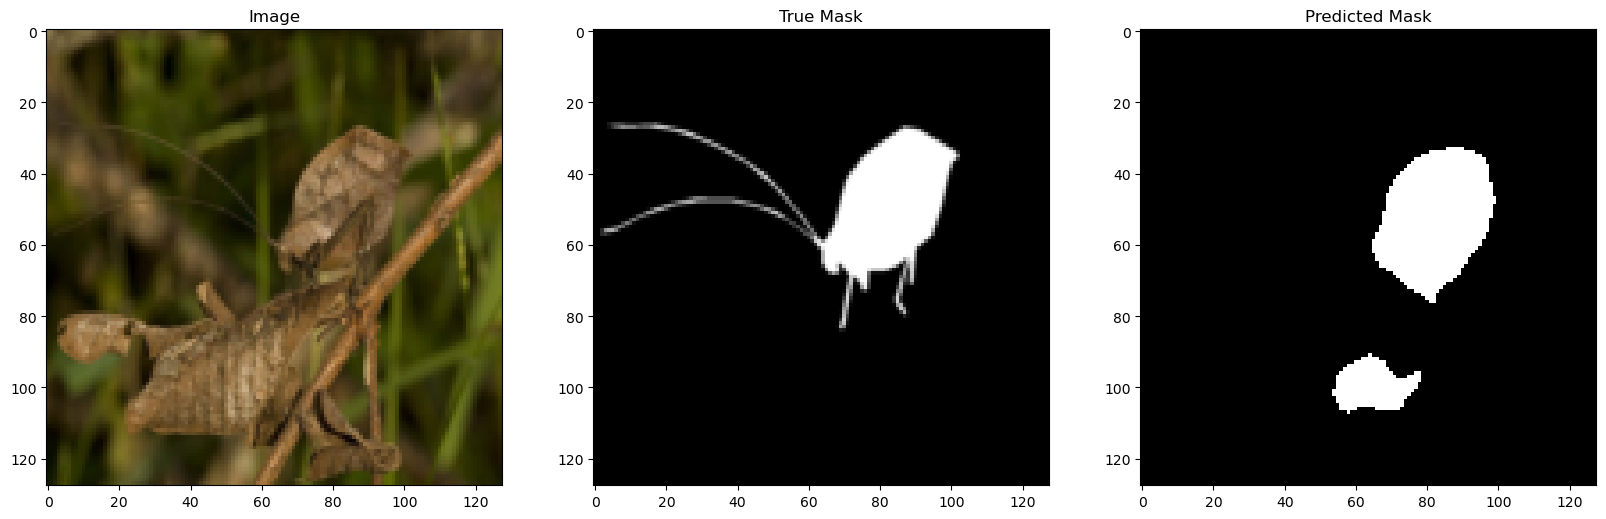

In [34]:
with torch.no_grad():
    image, mask = next(iter(val_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred1 = torch.relu(torch.sign(pred - threshold))
    image = image.to('cpu')
    image_show(image[0], mask[0], pred1[0])

In [26]:
IoU_value = 0
with torch.no_grad():
    for image, mask in val_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = unet(image).cpu()
        pred = torch.relu(torch.sign(pred - threshold))
        IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
    print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')

Intersection Over Union value = 0.36613172840419766


In [27]:
iou = IoU_value/len(val_loader)
dice_score = 2*iou/(1+iou)
print('Dice Score for Validation data =',dice_score)

Dice Score for Validation data = 0.5360123343769821


## Training for 10 more epochs

In [22]:
unet = torch.load('../models/U-Net_Image_Segmentation_IE643_Final_Dense.pt')
num_epochs = 5
batches = len(train_loader)
losses = []
print(batches)

125


In [23]:
criterion = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.SGD(unet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.6)

In [24]:
best_weights = copy.deepcopy(unet.state_dict())
max = 0.48
val_iou_score = 0
tic = time.time()
for epoch in range(num_epochs):
    unet.train()
    print(f'Epoch {epoch+1}/{num_epochs}; LR = {scheduler.get_last_lr()[0]}')
    for i, (images,masks) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks).to(device)

        preds = unet(images)
        loss = criterion(preds, masks) + criterion2(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    with torch.no_grad():
        unet.eval()
        val_iou_score = 0
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to('cpu')
            pred = unet(image).cpu()
            pred = torch.round(pred)
            val_iou_score += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
        val_iou_score = val_iou_score/len(val_loader)

        if (max <= val_iou_score):
            print('SAVED MODEL WEIGHTS')
            max = val_iou_score
            best_weights = copy.deepcopy(unet.state_dict())
    
    print(f'Validation IoU Score: {val_iou_score:.4f}')
    print(f'Validation Dice Score: {(2*val_iou_score)/(1+val_iou_score):.4f}')
    print("-"*20)
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/5; LR = 0.01
Step 1/125; Loss = 0.2752
Step 2/125; Loss = 0.2311
Step 3/125; Loss = 0.2254
Step 4/125; Loss = 0.2430
Step 5/125; Loss = 0.3149
Step 6/125; Loss = 0.3159
Step 7/125; Loss = 0.2771
Step 8/125; Loss = 0.2364
Step 9/125; Loss = 0.2178
Step 10/125; Loss = 0.2620
Step 11/125; Loss = 0.2745
Step 12/125; Loss = 0.2664
Step 13/125; Loss = 0.2991
Step 14/125; Loss = 0.3204
Step 15/125; Loss = 0.2524
Step 16/125; Loss = 0.2234
Step 17/125; Loss = 0.2652
Step 18/125; Loss = 0.3471
Step 19/125; Loss = 0.2335
Step 20/125; Loss = 0.2609
Step 21/125; Loss = 0.2562
Step 22/125; Loss = 0.2862
Step 23/125; Loss = 0.2376
Step 24/125; Loss = 0.2721
Step 25/125; Loss = 0.2235
Step 26/125; Loss = 0.2857
Step 27/125; Loss = 0.2663
Step 28/125; Loss = 0.3226
Step 29/125; Loss = 0.2696
Step 30/125; Loss = 0.2837
Step 31/125; Loss = 0.2682
Step 32/125; Loss = 0.2878
Step 33/125; Loss = 0.2718
Step 34/125; Loss = 0.2689
Step 35/125; Loss = 0.2731
Step 36/125; Loss = 0.2206
Step 37/125; Los

In [25]:
unet.load_state_dict(best_weights)
torch.save(unet, '../models/U-Net_Image_Segmentation_IE643_Final_Dense2.pt')

In [26]:
threshold = 0.39

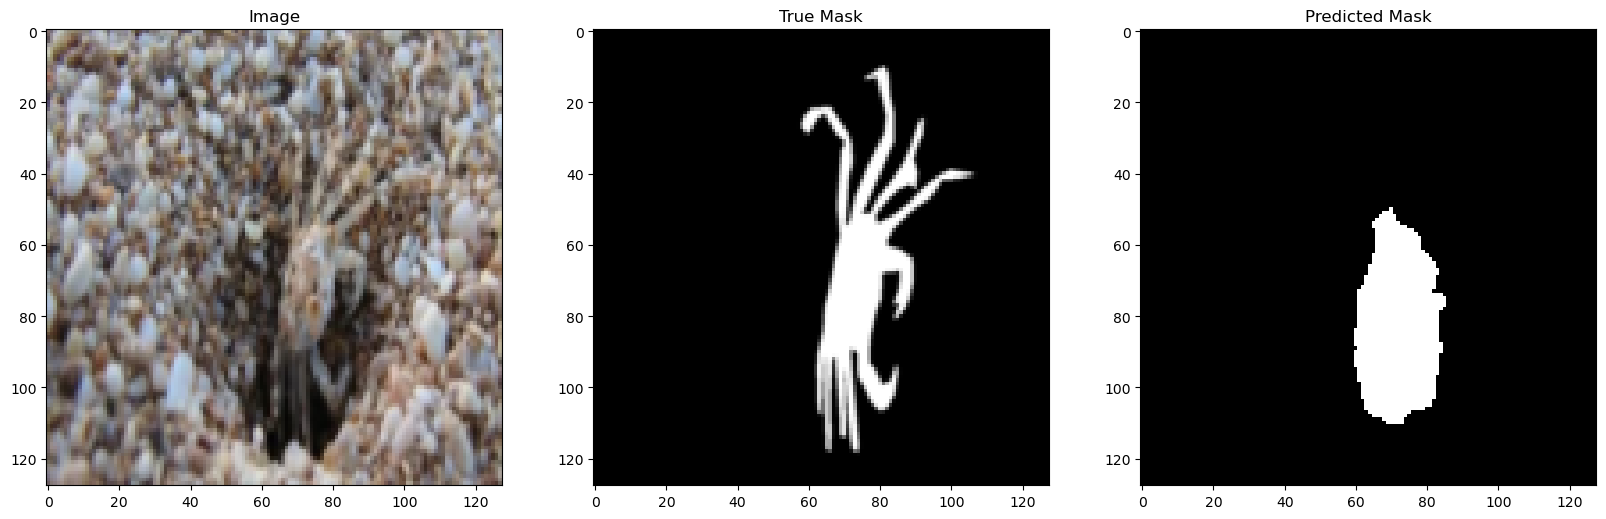

In [27]:
with torch.no_grad():
    image, mask = next(iter(train_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred1 = torch.relu(torch.sign(pred - threshold))
    image = image.to('cpu')
    image_show(image[0], mask[0], pred1[0])

In [ ]:
IoU_value = 0
with torch.no_grad():
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = unet(image).cpu()
        pred = torch.relu(torch.sign(pred - threshold)) # Taking 0.4 as the threshold to make the value 1
        IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
    print(f'Intersection Over Union value = {IoU_value/len(train_loader)}')
    iou = IoU_value/len(train_loader)
    dice_score = 2*iou/(1+iou)
    print('Dice Score for Training data =',dice_score)

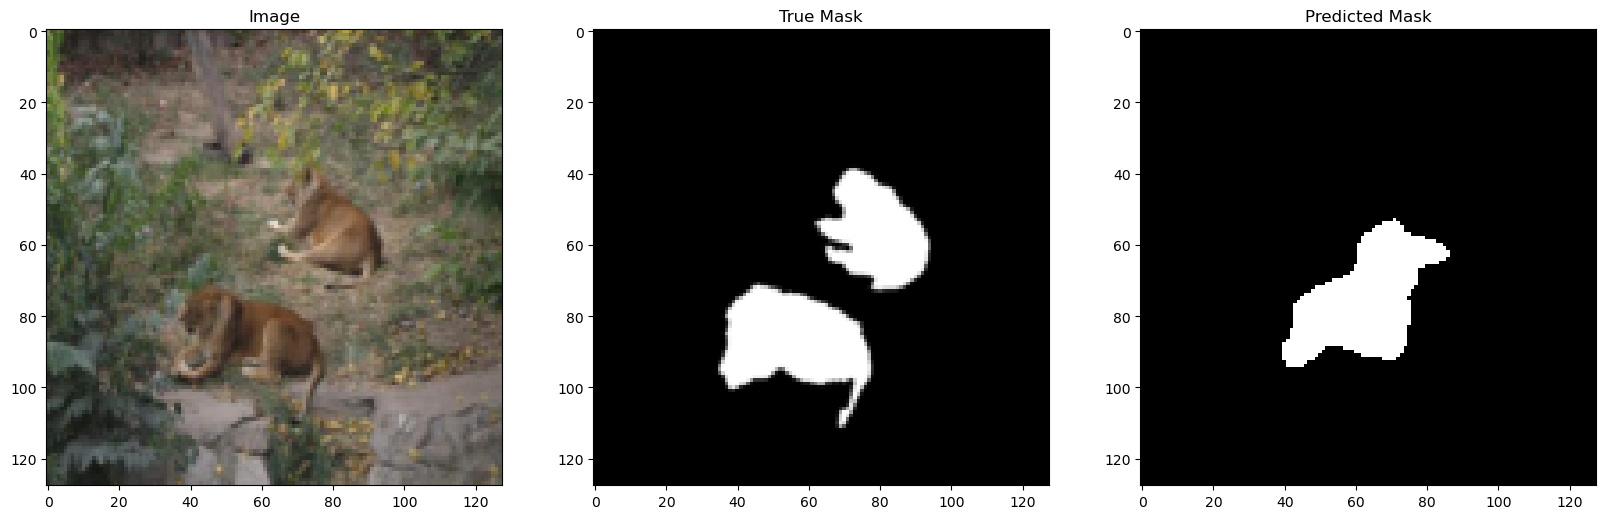

In [28]:
with torch.no_grad():
    image, mask = next(iter(val_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    pred1 = torch.relu(torch.sign(pred - threshold))
    image = image.to('cpu')
    image_show(image[0], mask[0], pred1[0])

In [29]:
IoU_value = 0
with torch.no_grad():
    for image, mask in val_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = unet(image).cpu()
        pred = torch.relu(torch.sign(pred - threshold)) # Taking 0.4 as the threshold to make the value 1
        IoU_value += binaryJaccardIndex(pred, torch.round(mask).type(torch.int16))
    print(f'Intersection Over Union value = {IoU_value/len(val_loader)}')
    iou = IoU_value/len(val_loader)
    dice_score = 2*iou/(1+iou)
    print('Dice Score for Validation data =',dice_score)

Intersection Over Union value = 0.3612247092110288
Dice Score for Validation data = 0.5307348695137867


In [ ]:
# torch.save(unet, '../models/U-Net_Image_Segmentation_IE643_Final_Dense.pt')